I have used the pre trained models provided by tensorflow Magenta Project. Visit https://github.com/tensorflow/magenta for more information

Need to change on of the dependencies due to support issues of Tensorflow Magenta<br>
Paper Demonstrated Here:https://arxiv.org/pdf/1610.07629.pdf

To run this on local machine you have to install tensorflow magenta alongwith tensorflow 1.15 and tensorflow-gpu=1.15 with other tools like scipy==1.1.0 and Pillow

In [0]:
!pip install scipy==1.1.0

     |████████████████████████████████| 31.2MB 103kB/s 
ERROR: plotnine 0.6.0 has requirement scipy>=1.2.0, but you'll have scipy 1.1.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


**Downloading the checkpoint files used in the paper**
Selecting the images and the checkpoint file corresponding to the required model.

In [0]:
from __future__ import absolute_import
from __future__ import print_function
from __future__ import division

import matplotlib.pyplot as plt
%matplotlib inline
%tensorflow_version 1.x
import ast
import os
import sys
import random
import numpy as np
import tensorflow as tf
from six.moves.urllib.request import urlopen

from magenta.models.image_stylization import image_utils
from magenta.models.image_stylization import model
from magenta.models.image_stylization import ops

def DownloadCheckpointFiles(checkpoint_dir='checkpoints'):
    """Download checkpoint files if necessary."""
    url_prefix = 'http://download.magenta.tensorflow.org/models/' 
    checkpoints = ['multistyle-pastiche-generator-monet.ckpt', 'multistyle-pastiche-generator-varied.ckpt']
    for checkpoint in checkpoints:
        full_checkpoint = os.path.join(checkpoint_dir, checkpoint)
        if not os.path.exists(full_checkpoint):
            print('Downloading {}'.format(full_checkpoint))
            response = urlopen(url_prefix + checkpoint)
            data = response.read()


            with open(full_checkpoint, 'wb') as fh:
                fh.write(data)

# create 'checkpoints' directory if it doesn't exist
if not os.path.isdir('checkpoints'):
    os.makedirs('checkpoints')

DownloadCheckpointFiles()

# Select an image (any jpg or png).
example_path = os.path.dirname(sys.modules['magenta.models.image_stylization'].__file__)
input_image = os.path.join(example_path, 'evaluation_images/guerrillero_heroico.jpg')

# Select a demo ('varied' or 'monet')
demo = 'varied'



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



**Combining the one or more learned styles in a single image**

In [0]:
demo='monet'



Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
keep_dims is deprecated, use keepdims instead

INFO:tensorflow:Restoring parameters from checkpoints/multistyle-pastiche-generator-monet.ckpt


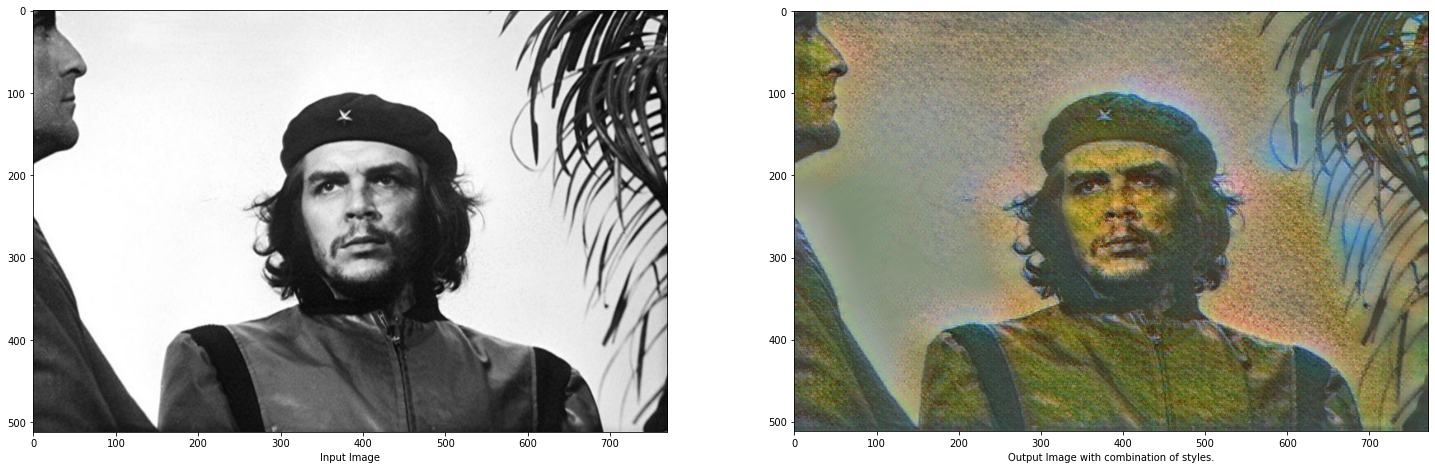

In [0]:
image = np.expand_dims(image_utils.load_np_image(
          os.path.expanduser(input_image)), 0)
if demo == 'monet':
    checkpoint = 'checkpoints/multistyle-pastiche-generator-monet.ckpt'
    num_styles = 10  # Number of images in checkpoint file. Do not change.
elif demo == 'varied':
    checkpoint = 'checkpoints/multistyle-pastiche-generator-varied.ckpt'
    num_styles = 32  # Number of images in checkpoint file. Do not change.
    
which_styles={0:0.5,1:0.5,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0}
num_rendered = len(which_styles)

with tf.Graph().as_default(), tf.Session() as sess:
    mixture = np.zeros([num_styles], dtype=np.float32)
    for index in which_styles:
        mixture[index] = which_styles[index]
    stylized_images = model.transform(
        image,
        normalizer_fn=ops.weighted_instance_norm,
        normalizer_params={
            'weights': tf.constant(mixture),
            'num_categories': num_styles,
            'center': True,
            'scale': True})
    model_saver = tf.train.Saver(tf.global_variables())
    model_saver.restore(sess, checkpoint)
    stylized_images = stylized_images.eval()
    
# Plot the images.
counter = 0
num_cols = 2
f, _ = plt.subplots(1, num_cols, figsize=(25, 25))
for counter, axis in enumerate(f.axes):
    if counter!=0:
      axis.imshow(stylized_images[0])
      axis.set_xlabel('Output Image with combination of styles.')
    else:
      axis.imshow(image[0])
      axis.set_xlabel('Input Image')
image_utils.save_np_image(stylized_images,'./combining_styles.png')

Demonstration of using the model to find the output images with various styles used to train the model.


INFO:tensorflow:Restoring parameters from checkpoints/multistyle-pastiche-generator-monet.ckpt


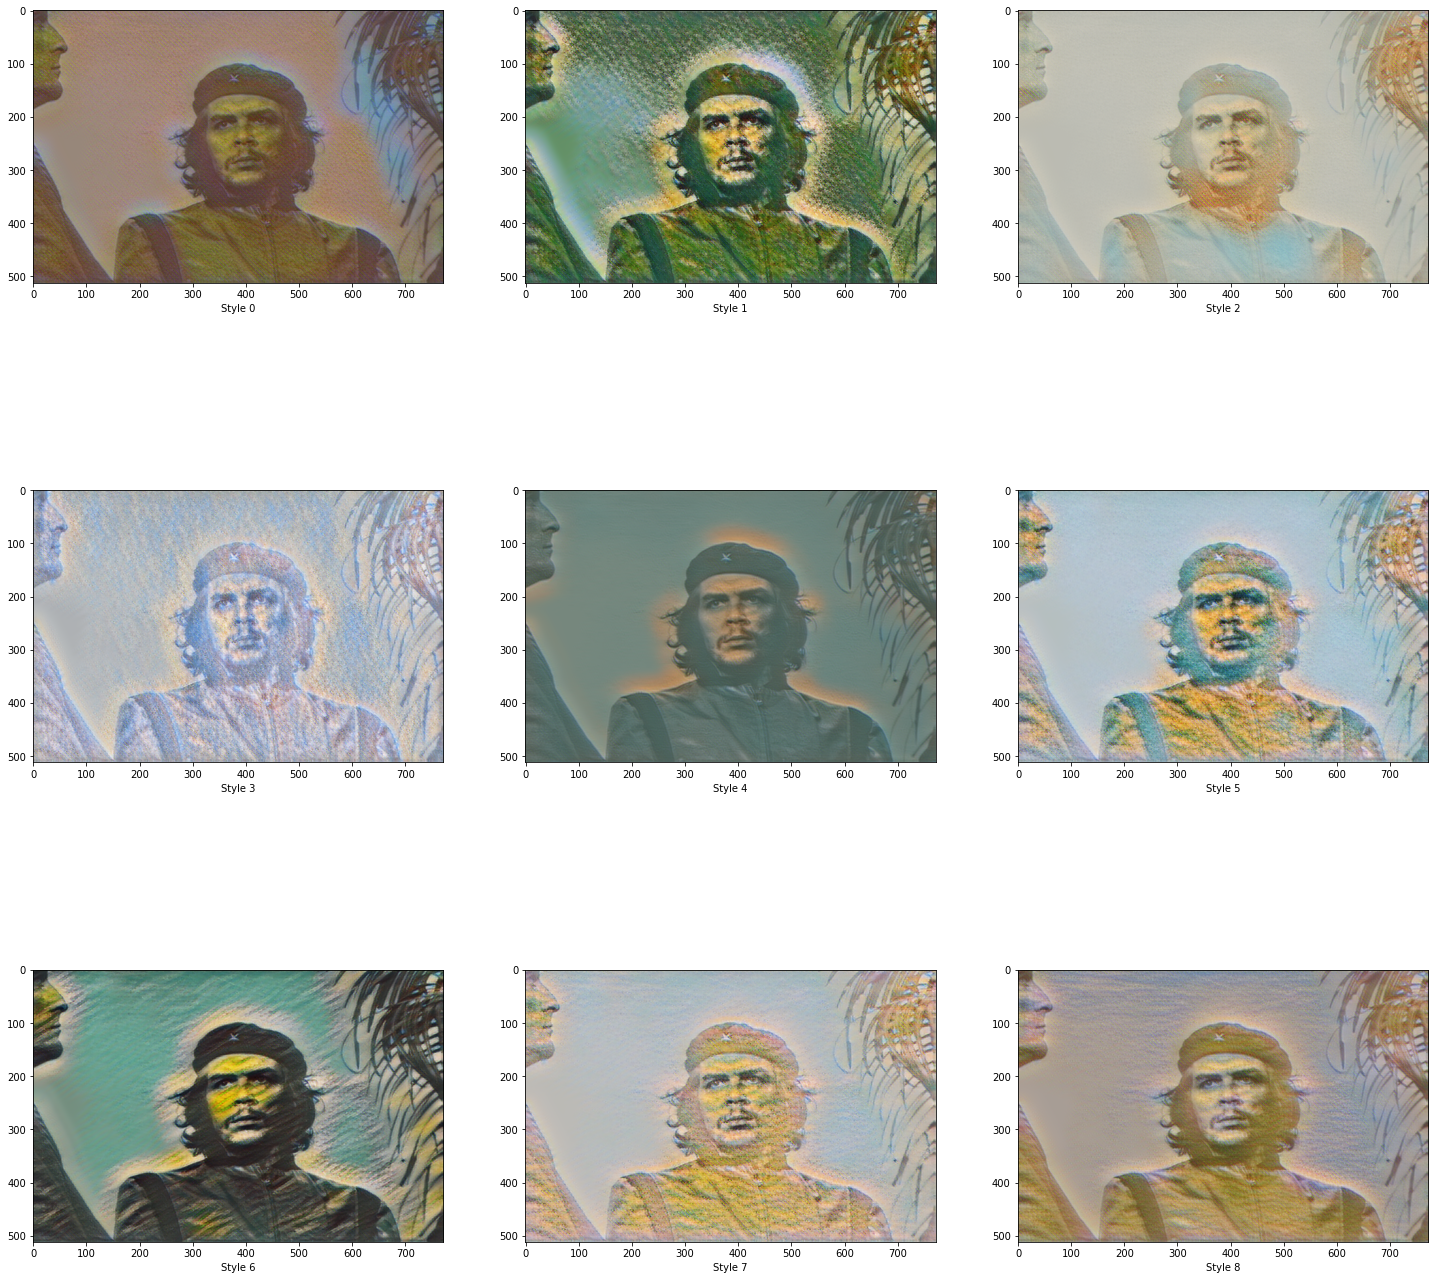

In [0]:
image = np.expand_dims(image_utils.load_np_image(
          os.path.expanduser(input_image)), 0)
if demo == 'monet':
    checkpoint = 'checkpoints/multistyle-pastiche-generator-monet.ckpt'
    num_styles = 10  # Number of images in checkpoint file. Do not change.
elif demo == 'varied':
    checkpoint = 'checkpoints/multistyle-pastiche-generator-varied.ckpt'
    num_styles = 32  # Number of images in checkpoint file. Do not change.
    
# These can be modified as per requirements. Here we randomly select six styles.
styles = list(range(num_styles))
# random.shuffle(styles)
which_styles = styles[0:9]
num_rendered = len(which_styles)

with tf.Graph().as_default(), tf.Session() as sess:
    stylized_images = model.transform(
        tf.concat([image for _ in range(num_rendered)], 0),
        normalizer_params={
            'labels': tf.constant(which_styles),
            'num_categories': num_styles,
            'center': True,
            'scale': True})
    model_saver = tf.train.Saver(tf.global_variables())
    model_saver.restore(sess, checkpoint)
    stylized_images = stylized_images.eval()
    
# Plot the images.
counter = 0
num_cols = 3
f, _ = plt.subplots(num_rendered // num_cols, num_cols, figsize=(25, 25))
for counter, axis in enumerate(f.axes):
    axis.imshow(stylized_images[counter])
    axis.set_xlabel('Style %i' % which_styles[counter])